In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
from xgboost import XGBRegressor

class CustomGBM:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.models = []
        self.initial_prediction = None

    def fit(self, X, y):
        self.initial_prediction = np.mean(y)
        y_pred = np.full(y.shape, self.initial_prediction)
        for _ in range(self.n_estimators):
            residual = y - y_pred
            model = DecisionTreeRegressor(max_depth=self.max_depth)
            model.fit(X, residual)
            update = self.learning_rate * model.predict(X)
            y_pred += update
            self.models.append(model)

    def predict(self, X):
        y_pred = np.full((X.shape[0],), self.initial_prediction)
        for model in self.models:
            y_pred += self.learning_rate * model.predict(X)
        return y_pred



df = pd.read_csv("Engineering_graduate_salary.csv")
df = df.head(500)
df.drop(columns=['ID'], inplace=True)
df.replace(-1, np.nan, inplace=True)
df.fillna(0, inplace=True)
df = pd.get_dummies(df, columns=['Gender', '10board', '12board', 'Degree', 'Specialization'], drop_first=True)
# 1. Drop extreme outliers in salary
q_low = df['Salary'].quantile(0.01)
q_high = df['Salary'].quantile(0.99)
df = df[(df['Salary'] > q_low) & (df['Salary'] < q_high)]

X = df.drop('Salary', axis=1)
y = np.log1p(df['Salary'])


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


dt_model = DecisionTreeRegressor(max_depth=3, random_state=42)
dt_model.fit(X_train, y_train)
dt_predictions = dt_model.predict(X_test)
joblib.dump(dt_model, 'decision_tree_model.pkl')


gbm = CustomGBM(n_estimators=100, learning_rate=0.1, max_depth=3)
gbm.fit(X_train, y_train)
joblib.dump(gbm, 'custom_gradient_booster_model.pkl')



xgb_model = XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
joblib.dump(xgb_model, 'gradient_booster_model.pkl')


['gradient_booster_model.pkl']

In [ ]:
decision_tree_model = joblib.load('decision_tree_model.pkl')
gradient_booster_model = joblib.load('gradient_booster_model.pkl')
custom_boosting_model = joblib.load('custom_gradient_booster_model.pkl')



y_pred_dt = decision_tree_model.predict(X)
mse_dt = mean_squared_error(y, y_pred_dt)
mae_dt = mean_absolute_error(y, y_pred_dt)
r2_dt = r2_score(y, y_pred_dt)

print(f"Decision Tree Regressor Performance:")
print(f"Mean Squared Error: {mse_dt:.4f}")
print(f"Mean Absolute Error: {mae_dt:.4f}")
print(f"R-squared: {r2_dt:.4f}")
y_pred_gbm = custom_boosting_model.predict(X)

mse_gbm = mean_squared_error(y, y_pred_gbm)
mae_gbm = mean_absolute_error(y, y_pred_gbm)
r2_gbm = r2_score(y, y_pred_gbm)

print(f"\nCustom Gradient Booster Performance:")
print(f"Mean Squared Error: {mse_gbm:.4f}")
print(f"Mean Absolute Error: {mae_gbm:.4f}")
print(f"R-squared: {r2_gbm:.4f}")

y_pred = xgb_model.predict(X)

# Calculate performance metrics based on the test set
mse_xgb = mean_squared_error(y, y_pred)
mae_xgb = mean_absolute_error(y, y_pred)
r2_xgb = r2_score(y, y_pred)

# Print the results
print("\nXGBoost Regressor Performance:")
print(f"Mean Squared Error: {mse_xgb:.4f}")
print(f"Mean Absolute Error: {mae_xgb:.4f}")
print(f"R-squared: {r2_xgb:.4f}")


Decision Tree Regressor Performance:
Mean Squared Error: 0.1734
Mean Absolute Error: 0.3308
R-squared: 0.2304

Custom Gradient Booster Performance:
Mean Squared Error: 0.1042
Mean Absolute Error: 0.2494
R-squared: 0.5374

XGBoost Regressor Performance:
Mean Squared Error: 0.1079
Mean Absolute Error: 0.2520
R-squared: 0.5210


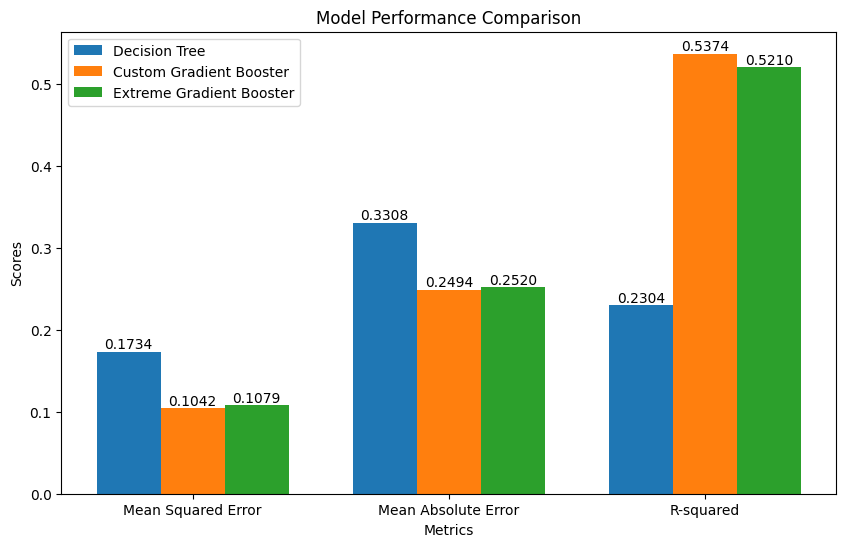

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ['Mean Squared Error', 'Mean Absolute Error', 'R-squared']
dt_scores = [mse_dt, mae_dt, r2_dt]
gbm_scores = [mse_gbm, mae_gbm, r2_gbm]
xgb_scores = [mse_xgb, mae_xgb, r2_xgb]

# Set up the bar chart parameters
x = np.arange(len(metrics))
width = 0.25  # Adjust the width to fit three bars

# Create the bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width, dt_scores, width, label='Decision Tree')
bars2 = ax.bar(x, gbm_scores, width, label='Custom Gradient Booster')
bars3 = ax.bar(x + width, xgb_scores, width, label='Extreme Gradient Booster')

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Display the values on top of each bar
for bar in bars1 + bars2 + bars3:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.4f}', ha='center', va='bottom')

plt.show()


In [ ]:
import gradio as gr
import joblib
import pandas as pd
import numpy as np

decision_tree_model = joblib.load('decision_tree_model.pkl')
gradient_booster_model = joblib.load('gradient_booster_model.pkl')
custom_boosting_model = joblib.load('custom_gradient_booster_model.pkl')

def predict_salary(
    ten_perc, twelve_perc, college_tier, college_gpa, college_city_tier,
    english, logical, quant, domain, comp_prog, elec_semicon, comp_sci,
    mech_engg, elec_engg, telecom_engg, civil_engg,
    gender, board10, board12, degree, specialization, model_choice
):
    input_dict = {
        '10percentage': ten_perc, '12percentage': twelve_perc, 'CollegeTier': college_tier,
        'collegeGPA': college_gpa, 'CollegeCityTier': college_city_tier,
        'English': english, 'Logical': logical, 'Quant': quant, 'Domain': domain,
        'ComputerProgramming': comp_prog, 'ElectronicsAndSemicon': elec_semicon,
        'ComputerScience': comp_sci, 'MechanicalEngg': mech_engg,
        'ElectricalEngg': elec_engg, 'TelecomEngg': telecom_engg, 'CivilEngg': civil_engg,
        'Gender': str(gender), '10board': str(board10), '12board': str(board12),
        'Degree': str(degree), 'Specialization': str(specialization)
    }

    df_input = pd.DataFrame([input_dict])
    categorical_features = ['Gender', '10board', '12board', 'Degree', 'Specialization']
    df_input = pd.get_dummies(df_input, columns=categorical_features, drop_first=True)

    expected_features = decision_tree_model.feature_names_in_
    for feature in expected_features:
        if feature not in df_input.columns:
            df_input[feature] = 0
    df_input = df_input[expected_features]

    if model_choice == "Decision Tree":
        pred_log = decision_tree_model.predict(df_input)[0]
    elif model_choice == "Gradient Booster":
        pred_log = gradient_booster_model.predict(df_input)[0]
    elif model_choice == "Custom Boosting":
        pred_log = custom_boosting_model.predict(df_input.values)[0]
    else:
        return "Invalid model selection."

    pred_salary = np.expm1(pred_log)
    return f"\U0001F4B8 Predicted Salary: ₹{pred_salary:,.2f}"

with gr.Blocks() as ui:
    gr.Markdown("# 🎓 Engineering Graduate Salary Predictor")
    gr.Markdown("Enter your academic and skill details to get a salary prediction.")

    with gr.Row():
        with gr.Column():
            gr.Markdown("### Academic Information")
            ten_perc = gr.Number(label="10th Percentage")
            twelve_perc = gr.Number(label="12th Percentage")
            college_tier = gr.Number(label="College Tier (1, 2, etc.)")
            college_gpa = gr.Number(label="College GPA")
            college_city_tier = gr.Number(label="College City Tier")

        with gr.Column():
            gr.Markdown("### Skills & Expertise")
            english = gr.Number(label="English Score")
            logical = gr.Number(label="Logical Score")
            quant = gr.Number(label="Quant Score")
            domain = gr.Number(label="Domain Score")

    with gr.Row():
        gr.Markdown("### Technical Skills")

    with gr.Row():
        comp_prog = gr.Number(label="Computer Programming")
        elec_semicon = gr.Number(label="Electronics & Semicon")
        comp_sci = gr.Number(label="Computer Science")
        mech_engg = gr.Number(label="Mechanical Engg")
        elec_engg = gr.Number(label="Electrical Engg")
        telecom_engg = gr.Number(label="Telecom Engg")
        civil_engg = gr.Number(label="Civil Engg")

    with gr.Row():
        gr.Markdown("### Additional Information")

    with gr.Row():
        gender = gr.Radio(["m", "f"], label="Gender")
        board10 = gr.Radio(["cbse", "other"], label="10th Board")
        board12 = gr.Radio(["cbse", "other"], label="12th Board")
        degree = gr.Radio(["B.Tech/B.E.", "other"], label="Degree")
        specialization = gr.Radio(["cse", "electronics & telecommunications", "other"], label="Specialization")
        model_choice = gr.Radio(["Decision Tree", "Gradient Booster", "Custom Boosting"], label="Select Model")

    predict_btn = gr.Button("Predict Salary")
    output = gr.Textbox(label="Prediction")

    predict_btn.click(predict_salary, inputs=[
        ten_perc, twelve_perc, college_tier, college_gpa, college_city_tier,
        english, logical, quant, domain, comp_prog, elec_semicon, comp_sci,
        mech_engg, elec_engg, telecom_engg, civil_engg,
        gender, board10, board12, degree, specialization, model_choice
    ], outputs=output)

ui.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d61e30fd70a471b6b2.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
pip install gradio